In [8]:
# imports and setup
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from keras_unet_collection import models, losses
from keras_unet.models import custom_unet
from matplotlib import pyplot as plt
from sklearn import metrics
from scipy import signal
from PIL import Image
import numpy as np
import json
import zipfile
import os
import rasterio
import cv2
from io import BytesIO
from tqdm import tqdm
import random
import pickle

In [2]:
# curve class: used to plot the Receiver Operating Characteristic (ROC) curve & to evaluate the performance of the classifier
# ROC curve is a graphical representation used to evaluate the performance of a binary classifier. It illustrates the trade-off between the
# true positive rate and the false positive rate
# AUC = 1: perfect model & AUC = 0.5 indicates a model with no discrimination ability 
class Curve:
    auc = 0 # area under curve set to 0

    def __init__(self, x, y):
        self.x = x
        self.y = y
    def plot(self, subfig): # plots ROC curve on subplot
        subfig.grid() # enables grid in subplot
        subfig.plot(self.x, self.y, lw=2) # lw = linewidth = 2 
        subfig.plot([0,1], [0,1], 'k--') # plots diagonal reference line from (0,0) to (1,1) with a dashed black line, representing a random classifier's
        # performance
        subfig.set_xlim([0.0, 1.0]) 
        subfig.set_ylim([0.0, 1.0])
        # previous 2 lines set x-axis and y-axis limits of the plot to a range from 0.0 to 1.0 (appropriate scale)
        subfig.set_xlabel('False Positive Rate', fontsize=12) # x-axis label
        subfig.set_ylabel('True Positive Rate', fontsize=12) # y-axis label
        subfig.set_title('AUC = %f' % (self.auc)) # sets title of the plot to be displayed as AUC value, where self.auc si formatted as a floating point
        # number
        x0, x1 = subfig.get_xlim()
        y0, y1 = subfig.get_ylim()
        # previous lines retrieve the current limits of the x-axis and y-axis
        subfig.set_aspect((x1-x0)/(y1-y0)) # sets AR of the plot to ensure that the scales of the x and y axes are equal, making the plot square.
        # important for ROC curves to interpret the rates correctly
        

### LDA & ROC Metric

147 observations are loaded.
**** Feature Extraction ****
X: (832659, 6)
y: (832659,)
Loading finished with 832659 instances in total.
**** Cross Validation ****
All images were used during training.
Accuracy: 0.77


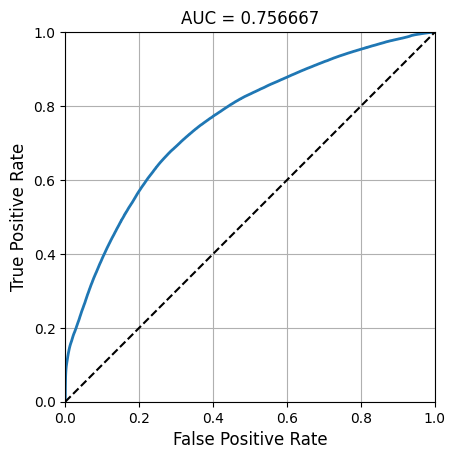

**** Test ****


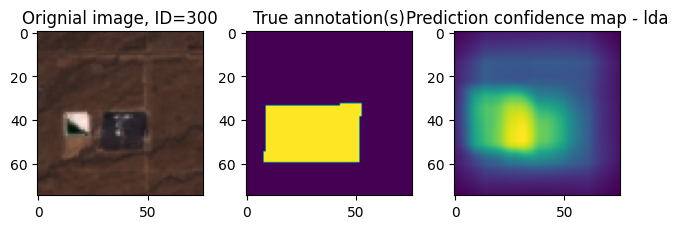

In [3]:
# observations class: responsible for loading data, extracting features, training the classifier, and testing it
class Observations:
    targets = {
        'root_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project", # root_dir where script is located
        'img_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat", # dir containing Landsat images
        'lab_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary", # dir containing binary annotation files
        'feat_file': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_metadata.geojson" # metadata file in GeoJSON format 
    }

    ## ATTRIBUTE INITIALIZATION ##
    X = [] # initializes a class-level attribute X as an empty list (will store feature vectors extracted from images)
    y = [] # initializes a class-level attribute y as an empty list (will store target labels corresponding to the feature vectors in X) 
    id_list = [] # will store unique IDs for the observations
    nElementsEach = [] # will store number of elements (pixels) in each image
    existence = [True, []] # list containing a boolean 'True' and an empty list. This will be used to check and report the existence of necessary files
    # and directories; existence[0]: a flag indicating whether all necessary files and directories exist, existence[1]: a list to store the paths 
    # of any missing files or directories 
    idx_all = [] # will store the indices of all elements (pixels) in the dataset
    idx_tr = [] # will store the indices of the training subset of the dataset
    idx_ts = [] # will store the indices of the testing subset of the dataset
    scr = [] # will store the scores (probabilities) predicted by the classifier for the testing subset
    sizes = [] # will store the sizes (dimensions) of each image in the dataset 
    method = 'lda' # linear discriminant analysis (LDA), i.e., default classification method

        # initialization and file checks
    def checkExist(self):
        if not os.path.exists(self.targets['root_dir']):
            self.existence[1].append(self.targets['root_dir'])
            self.existence[0] = False
        if not os.path.exists(os.path.join(self.targets['root_dir'], self.targets['img_dir'])):
            self.existence[1].append(self.targets['img_dir'])
            self.existence[0] = False
        if not os.path.exists(os.path.join(self.targets['root_dir'], self.targets['lab_dir'])):
            self.existence[1].append(self.targets['lab_dir'])
            self.existence[0] = False
        if not os.path.isfile(os.path.join(self.targets['root_dir'], self.targets['feat_file'])):
            self.existence[1].append(self.targets['feat_file'])
            self.existence[0] = False
                            
    def __init__(self, *args):
        self.checkExist() # checks whether everything exists to proceed
        if not self.existence[0]:
            print('Cannot find the following item(s), please check: \n%s' %
                  '\n'.join(map(str, self.existence[1])))
            sys.exit()
    
        self.windowSize = args[0]
        self.loadObservations()


        # loadObservations: method loads metadata, extracts features from images, and pairs them with corresponding annotations
    def loadObservations(self):
        with open(self.targets['feat_file']) as f:
            self.obs = json.load(f)['features']
            # parser = ijson.parse(f)
            # for prefix, event, value in parser:
            #     if (prefix, event) == ('features.item', 'map_key'):
            #         self.obs.append(value) # opens geojson file containing metadata
            
        print('%d observations are loaded.'%(len(self.obs))) # prints number of observations loaded
        print('**** Feature Extraction ****') # prints a message indicating the start of feature extraction
    
        # initializing parameters
        self.nFeatures = 6 # sets number of features to be extracted for each pixel to 6 (mean & variance for R, G, and B channels)
        windowDiameter = 2 * self.windowSize -1 # calculates diameter of the window used for feature extraction
        nPixelsInWindow = pow(windowDiameter, 2) # calculates the total number of pixels in the window
        convMask = np.ones([windowDiameter] * 2) # creates a convolution mask of size windowDiameter x windowDiameter filled with ones 

        # initializing X and y 
        self.X = np.array([]).reshape(0, self.nFeatures) # shape 0, 6 to store features
        self.y = np.array([]).reshape(0,1) # shape 0, 1 to store labels
        
        
        for i in range(0, len(self.obs)): # loops through each observation
            ob_temp = self.obs[i] # temporarily stores the current observation 
            self.id_list.append(ob_temp['properties']['egrid_ID']) # appends observation's 'egrid_ID' to 'self.id_list'
    
            # constructs file names and loads
            # constructs image file name based on metadata proeprties: 
            img_name = 'ls8_' + self.id_list[-1] + '_' + ob_temp['properties']['state_name'] + '_' + ob_temp['properties']['primary_fuel'] + '.tif'
            # constructs the label file name based on 'egrid_ID'
            lab_name = 'bilabels_' + self.id_list[-1] + '.png'
            img = np.array(Image.open(os.path.join(self.targets['img_dir'], img_name)))
            lab = np.array(np.array(Image.open(os.path.join(self.targets['lab_dir'], lab_name)).resize(img.shape[:2][::-1])) > 0)

            self.sizes.append(lab.shape) # appends the shape of the label image to 'self.sizes'

            # extract features
            # number of pixels in the whole image
            nPixels = np.multiply(lab.shape[0], lab.shape[1]) # tot. # of pixels in label image
            # initialize feature vector
            features = np.empty((nPixels, self.nFeatures)) # initializes empty array 'features' to store extracted featues for each pixel
            features[:] = np.nan # fills array with NaNs to initializes

            for iChannel in range(0, img.shape[2]): # loops through each color channel (R,G,B) in the image
                cChannel = np.squeeze(img[:, :, iChannel]) # extracts current color channel
    
                cChannelMean = (1 / nPixelsInWindow) * signal.convolve2d(cChannel, convMask, mode='same') # computes mean of the pixels
                # within the window for the current channel
                cChannelMeanSquare = (1 / nPixelsInWindow) * signal.convolve2d(np.square(cChannel), convMask, mode='same') # computes mean 
                # of the squares of the pixels within the window for the current channel
                cChannelVariance = cChannelMeanSquare - np.square(cChannelMean) # computes the variance of the pixels
                # within the window for the current channel

                # store the features
                features[:, iChannel] = cChannelMean.reshape(nPixels, order='C') - np.mean(cChannelMean) # stores the mean features
                # for the current channel in 'features'
                features[:, iChannel + img.shape[2]] = cChannelVariance.reshape(nPixels, order='C') - np.mean(cChannelVariance) # stores the 
                # variance feature for the current channel in 'features'

            self.X = np.vstack((self.X, features)) # appends extracted features to self.X
            self.y = np.vstack((self.y, lab.reshape((nPixels, 1), order='C'))) # appends reshaped labels to self.y
            self.nElementsEach.append(nPixels) # appends number of pixels in current image to self.nElementsEach

        self.y = self.y.reshape(self.y.shape[0]) # reshapes self.y to a 1D array
        self.idx_all = np.random.permutation(len(self.y)) # creates shuffled array of indices for all the labels

        print('X: ' + str(self.X.shape))
        print('y: ' + str(self.y.shape))
        print(('Loading finished with %d instances in total.') % (len(self.y)))
    
    def crossValidate(self, *args):
        # Method performs cross-validation, splitting the data into training and testing subsets
        print('**** Cross Validation ****')
        
        # Number of folds for cross-validation
        nfolder = args[0]
        
        # Method to use for classification (e.g., 'lda' or 'rf')
        self.method = args[1]
        
        # Initialize array to store prediction scores for each sample
        score = np.zeros(len(self.y))
        
        # Calculate the size of each fold
        fz = len(self.X) / nfolder
        
        # Tracker to ensure that all images are used in training
        image_usage_tracker = np.zeros(len(self.X), dtype=bool)
    
        # Iterate over each fold
        for ff in range(nfolder):
            print(f'Working on the {ff + 1} of {nfolder} folds...', end='\r')
            
            # Set indices for the current test fold
            self.idx_ts = self.idx_all[int(fz * ff):int(fz * (ff + 1))]
            
            # Set indices for the training data (excluding the test fold)
            self.idx_tr = np.setdiff1d(self.idx_all, self.idx_ts)
            
            # Update the tracker to mark images used in training
            image_usage_tracker[self.idx_tr] = True
            
            # Train the model on the training subset and predict on the testing subset
            self.trainAndPredict()
            
            # Store prediction scores for the current test fold
            score[self.idx_ts] = np.array([item[1] for item in self.scr])
        
        # Check if all images were used during training
        if np.all(image_usage_tracker):
            print("All images were used during training.")
        else:
            print("Warning: Some images were not used during training.")
        
        # Calculate ROC (Receiver Operating Characteristic) curve metrics
        pf, pd, _ = metrics.roc_curve(self.y, score)
        self.cross_roc = Curve(pf, pd)
        
        # Calculate the AUC (Area Under the Curve) score
        self.cross_roc.auc = metrics.roc_auc_score(self.y, score)
    
        # Print accuracy
        y_pred = np.array([1 if s[1] > 0.5 else 0 for s in self.scr])  # Convert probabilities to binary labels
        accuracy = np.mean(y_pred == self.y[self.idx_ts])  # Compute accuracy
        print(f'Accuracy: {accuracy:.2f}')
        
        # Plot ROC curve
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        self.cross_roc.plot(ax1)
        plt.show()


    def trainAndPredict(self): # trains classifier on training subset & predicts probability for testing subset
        # train on training subset
        if self.method == 'lda':
            mdl = lda().fit(self.X[self.idx_tr, :], self.y[self.idx_tr])
        elif self.method == 'rf':
            mdl = rfc(n_estimators=100).fit(
                self.X[self.idx_tr, :], self.y[self.idx_tr])
        # test on testing subset
        self.scr = mdl.predict_proba(self.X[self.idx_ts, :])

    def test(self, test_list, *med_opt):
        print('**** Test ****')
        if len(med_opt):
            self.method = med_opt[0]
        for test_item in test_list:
            # confirm test_item is in range
            if str(test_item) not in self.id_list:
                print('Test case not found')
                continue 
            # find which one is to be tested
            test_img_idx = self.id_list.index(str(test_item))

            # find pixel-wise indecies
            ts_start = np.array(self.nElementsEach[:test_img_idx]).sum()
            ts_end = ts_start + self.nElementsEach[test_img_idx]
            self.idx_ts = list(range(int(ts_start), int(ts_end)))
            self.idx_tr = np.setdiff1d(self.idx_all, self.idx_ts)

            # train and predict
            self.trainAndPredict()
            # make confidence map
            self.genConfMap(test_img_idx, test_item)

    def genConfMap(self, test_img_idx, test_item):
        fig = plt.figure()
        # display cmap
        ax1 = fig.add_subplot(133)
        ax1.imshow(np.reshape([item[1] for item in self.scr], 
                              self.sizes[test_img_idx], order='C'))
        ax1.set_title('Prediction confidence map - ' + self.method)

        # display true annotation
        ax2 = fig.add_subplot(132)
        ax2.imshow(np.reshape(self.y[self.idx_ts],
                              self.sizes[test_img_idx], order='C'))
        ax2.set_title('True annotation(s)')

        # display original image
        ax3 = fig.add_subplot(131)
        ob = next(
            (item for item in self.obs if item['properties']['egrid_ID'] == str(test_item)))
        fname = 'ls8_' + ob['properties']['egrid_ID'] + '_' + \
            ob['properties']['state_name'] + '_' + \
            ob['properties']['primary_fuel'] + '.tif'
        orig_img = Image.open(os.path.join(
            self.targets['root_dir'], self.targets['img_dir'], fname))
        ax3.imshow(np.array(orig_img))
        ax3.set_title('Orignial image, ID=' + ob['properties']['egrid_ID'])

        plt.tight_layout()
        plt.show()
        

if __name__ == '__main__':
    obs_class = Observations(15)
    obs_class.crossValidate(4, 'lda')
    obs_class.test([300], 'lda')
        

### Display Features in Metadata

In [4]:
geo_json = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_metadata.geojson"
def display_geojson(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        geojson_data = json.load(file)
    if 'features' not in geojson_data:
        print("No features found in the GeoJSON file.")
        return

    for feature in geojson_data['features']:
        if 'properties' in feature:
            print("Feature Properties")
            for key, value in feature['properties'].items():
                print(f" {key}: {value}")
            print("\n")
        else:
            print("No properties found for this feature.\n")

display_geojson(geo_json)

Feature Properties
 egrid_ID: 300
 plant_name: Black Mountain Generating Station
 state_name: AZ
 county_name: MOHAVE
 primary_fuel: NG
 fossil_fuel: GAS
 capacity_factor: 0.049
 nameplate_cap_MW: 121.0
 co2_emission: 30564.6130614826
 availability: NAIP&LANDSAT


Feature Properties
 egrid_ID: 303
 plant_name: Buckeye Generation Center, LLC
 state_name: AZ
 county_name: Maricopa
 primary_fuel: NG
 fossil_fuel: GAS
 capacity_factor: 
 nameplate_cap_MW: 652.2
 co2_emission: 0.0
 availability: NAIP&LANDSAT


Feature Properties
 egrid_ID: 304
 plant_name: Buckeye Union HS District 201
 state_name: AZ
 county_name: Maricopa
 primary_fuel: SUN
 fossil_fuel: SOLAR
 capacity_factor: 0.256
 nameplate_cap_MW: 3.3
 co2_emission: 0.0
 availability: NAIP&LANDSAT


Feature Properties
 egrid_ID: 306
 plant_name: Chino Solar Valley
 state_name: AZ
 county_name: Yavapai
 primary_fuel: SUN
 fossil_fuel: SOLAR
 capacity_factor: 0.283
 nameplate_cap_MW: 19.0
 co2_emission: 0.0
 availability: NAIP&LANDSAT


### LDA & Other Performance Metrics

147 observations are loaded.
**** Feature Extraction ****
X: (832659, 6)
y: (832659,)
Loading finished with 832659 instances in total.
**** Cross Validation ****
Working on the 4 of 4 folds...
Cross-validation results:
Accuracy: 0.7712
Precision: 0.6686
Recall: 0.2308
F1 Score: 0.3431
Confusion Matrix:
 [[148098   6165]
 [ 41461  12439]]
**** Test ****


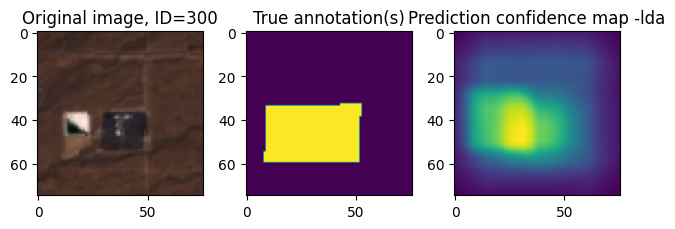


Test performance:
Accuracy: 0.8902
Precision: 0.9076
Recall: 0.5009
F1 Score: 0.6455
Confusion Matrix:
 [[4504   58]
 [ 568  570]]


In [8]:
### LDA & OTHER PERFORMANCE METRICS ###
import os
import sys
import json
import numpy as np
from PIL import Image
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from scipy import signal

# Observations class: responsible for loading data, extracting features, training the classifier, and testing it
class Observations:
    targets = {
        'root_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project",
        'img_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat",
        'lab_dir': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary",
        'feat_file': r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_metadata.geojson"
    }

    def __init__(self, *args):
        self.X = []
        self.y = []
        self.id_list = []
        self.nElementsEach = []
        self.existence = [True, []]
        self.idx_all = []
        self.idx_tr = []
        self.idx_ts = []
        self.scr = []
        self.sizes = []
        self.method = 'lda'
        self.checkExist()
        if not self.existence[0]:
            print('Cannot find the following item(s), please check: \n%s' %
                  '\n'.join(map(str, self.existence[1])))
            sys.exit()
        self.windowSize = args[0]
        self.loadObservations()

    def checkExist(self):
        if not os.path.exists(self.targets['root_dir']):
            self.existence[1].append(self.targets['root_dir'])
            self.existence[0] = False
        if not os.path.exists(self.targets['img_dir']):
            self.existence[1].append(self.targets['img_dir'])
            self.existence[0] = False
        if not os.path.exists(self.targets['lab_dir']):
            self.existence[1].append(self.targets['lab_dir'])
            self.existence[0] = False
        if not os.path.isfile(self.targets['feat_file']):
            self.existence[1].append(self.targets['feat_file'])
            self.existence[0] = False

    def loadObservations(self):
        with open(self.targets['feat_file']) as f:
            self.obs = json.load(f)['features']
        print('%d observations are loaded.' % (len(self.obs)))
        print('**** Feature Extraction ****')
        self.extractFeatures()

    def extractFeatures(self):
        self.nFeatures = 6
        windowDiameter = 2 * self.windowSize - 1
        nPixelsInWindow = pow(windowDiameter, 2)
        convMask = np.ones([windowDiameter] * 2)
        self.X = np.empty((0, self.nFeatures))
        self.y = np.empty((0, 1))

        for ob in self.obs:
            self.id_list.append(ob['properties']['egrid_ID'])
            img_name = 'ls8_' + self.id_list[-1] + '_' + ob['properties']['state_name'] + '_' + ob['properties']['primary_fuel'] + '.tif'
            lab_name = 'bilabels_' + self.id_list[-1] + '.png'
            img = np.array(Image.open(os.path.join(self.targets['img_dir'], img_name)))
            lab = np.array(np.array(Image.open(os.path.join(self.targets['lab_dir'], lab_name)).resize(img.shape[:2][::-1])) > 0)

            self.sizes.append(lab.shape)
            nPixels = np.multiply(lab.shape[0], lab.shape[1])
            features = np.empty((nPixels, self.nFeatures))
            features[:] = np.nan

            for iChannel in range(0, img.shape[2]):
                cChannel = np.squeeze(img[:, :, iChannel])
                cChannelMean = (1 / nPixelsInWindow) * signal.convolve2d(cChannel, convMask, mode='same')
                cChannelMeanSquare = (1 / nPixelsInWindow) * signal.convolve2d(np.square(cChannel), convMask, mode='same')
                cChannelVariance = cChannelMeanSquare - np.square(cChannelMean)
                features[:, iChannel] = cChannelMean.reshape(nPixels, order='C') - np.mean(cChannelMean)
                features[:, iChannel + img.shape[2]] = cChannelVariance.reshape(nPixels, order='C') - np.mean(cChannelVariance)

            self.X = np.vstack((self.X, features))
            self.y = np.vstack((self.y, lab.reshape((nPixels, 1), order='C')))
            self.nElementsEach.append(nPixels)

        self.y = self.y.reshape(self.y.shape[0])
        self.idx_all = np.random.permutation(len(self.y))

        print('X: ' + str(self.X.shape))
        print('y: ' + str(self.y.shape))
        print(('Loading finished with %d instances in total.') % (len(self.y)))

    def crossValidate(self, n_folds, method='lda'):
        print('**** Cross Validation ****')
        self.method = method
        scores = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
        confusion_matrices = []
        fold_size = len(self.X) // n_folds

        for ff in range(n_folds):
            print('Working on the %d of %d folds...' % (ff + 1, n_folds), end='\r')
            self.idx_ts = self.idx_all[int(fold_size * ff):int(fold_size * (ff + 1))]
            self.idx_tr = np.setdiff1d(self.idx_all, self.idx_ts)
            self.trainAndPredict()
            y_true = self.y[self.idx_ts]
            y_pred = np.argmax(self.scr, axis=1)
            scores['accuracy'].append(accuracy_score(y_true, y_pred))
            scores['precision'].append(precision_score(y_true, y_pred))
            scores['recall'].append(recall_score(y_true, y_pred))
            scores['f1'].append(f1_score(y_true, y_pred))
            confusion_matrices.append(confusion_matrix(y_true, y_pred))

        print('\nCross-validation results:')
        print('Accuracy: %.4f' % np.mean(scores['accuracy']))
        print('Precision: %.4f' % np.mean(scores['precision']))
        print('Recall: %.4f' % np.mean(scores['recall']))
        print('F1 Score: %.4f' % np.mean(scores['f1']))
        print('Confusion Matrix:\n', np.mean(confusion_matrices, axis=0).astype(int))

    def trainAndPredict(self):
        if self.method == 'lda':
            mdl = LDA().fit(self.X[self.idx_tr, :], self.y[self.idx_tr])
        self.scr = mdl.predict_proba(self.X[self.idx_ts, :])

    def test(self, test_list, method='lda'):
        print('**** Test ****')
        self.method = method
        for test_item in test_list:
            if str(test_item) not in self.id_list:
                print('Test case not found')
                continue
            test_img_idx = self.id_list.index(str(test_item))
            ts_start = np.array(self.nElementsEach[:test_img_idx]).sum()
            ts_end = ts_start + self.nElementsEach[test_img_idx]
            self.idx_ts = list(range(int(ts_start), int(ts_end)))
            self.idx_tr = np.setdiff1d(self.idx_all, self.idx_ts)
            self.trainAndPredict()
            self.genConfMap(test_img_idx, test_item)
            self.evaluatePerformance()

    def genConfMap(self, test_img_idx, test_item):
        fig = plt.figure()
        ax1 = fig.add_subplot(133)
        ax1.imshow(np.reshape([item[1] for item in self.scr],
                              self.sizes[test_img_idx], order='C'))
        ax1.set_title('Prediction confidence map -' + self.method)

        ax2 = fig.add_subplot(132)
        ax2.imshow(np.reshape(self.y[self.idx_ts],
                              self.sizes[test_img_idx], order='C'))
        ax2.set_title('True annotation(s)')

        ax3 = fig.add_subplot(131)
        ob = next(
            (item for item in self.obs if item['properties']['egrid_ID'] == str(test_item)))
        fname = 'ls8_' + ob['properties']['egrid_ID'] + '_' + \
                ob['properties']['state_name'] + '_' + \
                ob['properties']['primary_fuel'] + '.tif'
        orig_img = Image.open(os.path.join(
            self.targets['img_dir'], fname))
        ax3.imshow(np.array(orig_img))
        ax3.set_title('Original image, ID=' + ob['properties']['egrid_ID'])

        plt.tight_layout()
        plt.show()

    def evaluatePerformance(self):
        y_true = self.y[self.idx_ts]
        y_pred = np.argmax(self.scr, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        conf_matrix = confusion_matrix(y_true, y_pred)
        print('\nTest performance:')
        print('Accuracy: %.4f' % accuracy)
        print('Precision: %.4f' % precision)
        print('Recall: %.4f' % recall)
        print('F1 Score: %.4f' % f1)
        print('Confusion Matrix:\n', conf_matrix)


if __name__ == '__main__':
    obs_class = Observations(15)
    obs_class.crossValidate(4, 'lda')
    obs_class.test([300], 'lda')


### Custom CNN

In [10]:
## DIRECTORY SETUP

img_dir = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat" 
mask_dir = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary" 

SIZE = 256
image_dataset = []
mask_dataset = []

# DATA EXTRACTION
image_paths = {}
images = os.listdir(img_dir)
print("Loading images...")
for image_name in tqdm(images, desc='Images'):
    if image_name.endswith('.tif'):
        image_id = image_name.split('_')[1]  
        img_path = os.path.join(img_dir, image_name)
        image_paths[image_id] = img_path

print(f"Image IDs: {list(image_paths.keys())[:10]}")  # first 10 IDs for debugging


mask_paths = {}
masks = os.listdir(mask_dir)
print("Loading masks...")
for mask_name in tqdm(masks, desc="Masks"):
    if mask_name.endswith('.png'):
        mask_id = mask_name.split('_')[1].replace('.png', '')  
        mask_path = os.path.join(mask_dir, mask_name)
        mask_paths[mask_id] = mask_path

print(f"Mask IDs: {list(mask_paths.keys())[:10]}")  # first 10 IDs for debugging

# LOADING AND RESIZING
print("Processing images and masks...")
for image_id, img_path in tqdm(image_paths.items(), desc='Processing Images'):
    if image_id in mask_paths:
        # Load and resize image
        image = cv2.imread(img_path, 0)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

        # Load and resize mask
        mask_path = mask_paths[image_id]
        mask = cv2.imread(mask_path, 0)
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            continue
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))

print(f"Number of matched images: {len(image_dataset)}")
print(f"Number of matched masks: {len(mask_dataset)}")


Loading images...


Images: 100%|██████████████████████████████████████████████████████████████████| 4455/4455 [00:00<00:00, 177907.50it/s]


Image IDs: ['1002', '1003', '1005', '1007', '1009', '1011', '1013', '1014', '1015', '1016']
Loading masks...


Masks: 100%|███████████████████████████████████████████████████████████████████| 4454/4454 [00:00<00:00, 284886.47it/s]


Mask IDs: ['1002', '1003', '1005', '1007', '1009', '1011', '1013', '1014', '1015', '1016']
Processing images and masks...


Processing Images: 100%|███████████████████████████████████████████████████████████| 4454/4454 [01:42<00:00, 43.64it/s]

Number of matched images: 4454
Number of matched masks: 4454


In [11]:
## PREPROCESSING

def normalize_image(image):
    """Normalize the image to [0, 1] range."""
    return (image.astype(float) - np.min(image)) / (np.max(image) - np.min(image))


normalized_images = []
for img in tqdm(image_dataset, desc='Normalizing Images'):
    normalized_img = normalize_image(img)
    normalized_img = np.expand_dims(normalized_img, axis=-1)  
    normalized_images.append(normalized_img)
image_dataset = np.array(normalized_images)

# Normalize masks and expand dimensions
mask_dataset = np.array(mask_dataset)
mask_dataset = np.expand_dims(mask_dataset, axis=-1) / 255.0  

print("Preprocessing completed.")

Normalizing Images: 100%|████████████████████████████████████████████████████████| 4454/4454 [00:02<00:00, 1728.75it/s]


Preprocessing completed.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=42)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (4008, 256, 256, 1), (4008, 256, 256, 1)
Testing set: (446, 256, 256, 1), (446, 256, 256, 1)


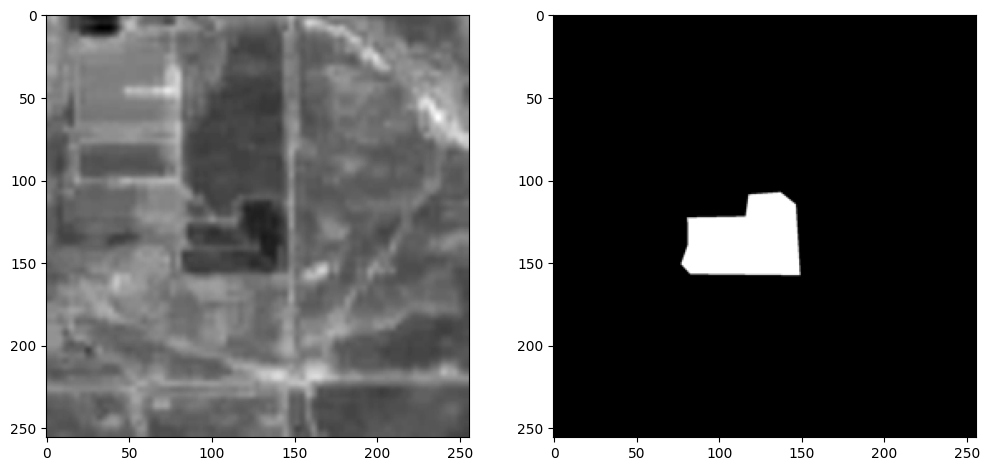

In [11]:
# sanity check
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [16]:
def buildCNNModel(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    
    # Decoder
    u3 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    
    u2 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    u1 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
input_shape = (256, 256, 1)
model = buildCNNModel(input_shape)

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=24,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False)
model.save('custom_CNN.h5')

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.7982 - loss: 0.5190 - val_accuracy: 0.7859 - val_loss: 0.4829
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.7984 - loss: 0.4581 - val_accuracy: 0.7863 - val_loss: 0.4672
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.7983 - loss: 0.4501 - val_accuracy: 0.7861 - val_loss: 0.4741
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.7990 - loss: 0.4460 - val_accuracy: 0.7878 - val_loss: 0.4560
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.7996 - loss: 0.4407 - val_accuracy: 0.7907 - val_loss: 0.4501
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7999 - loss: 0.4378 - val_accuracy: 0.7912 - val_loss: 0.4487
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.8005 - loss: 0.4365 - val_accuracy: 0.7922 - val_loss: 0.4468
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.8010 - loss: 0.4350 - val_accu

In [20]:
def save_history(history, filename):
    with open(filename, 'wb') as file:
        pickle.dump(history.history, file)
#save_history(history, r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\custom_CNN.pkl')

In [12]:
# evaluate model
model = load_model(r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\custom_CNN.h5')
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - accuracy: 0.7831 - loss: 0.4529
Accuracy =  79.26434278488159 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


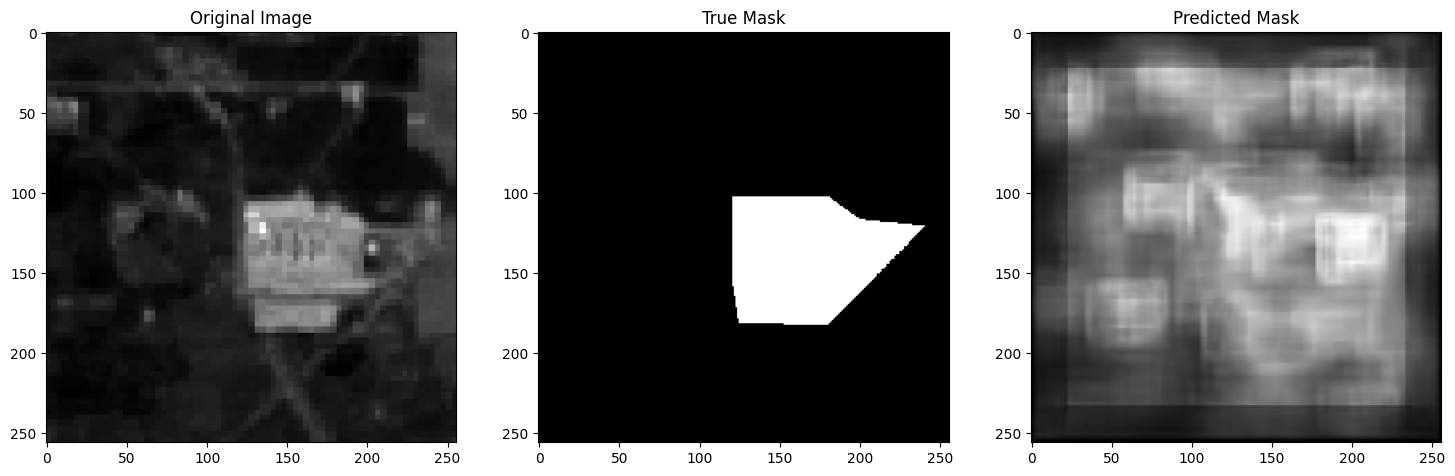

In [22]:
### SANITY CHECK ###

# Load the model
model_path = r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\custom_CNN.h5'  # Update this with your model's path
model = load_model(model_path)

def preprocess_image(image_path, target_size):
    # Load image as grayscale
    image = load_img(image_path, target_size=target_size, color_mode='grayscale')
    image = img_to_array(image)
    image = image / 255.0  # Normalize image
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def load_true_mask(mask_path, target_size):
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    mask = img_to_array(mask)
    mask = mask / 255.0  # Normalize mask
    return mask

def visualize_predictions(image, true_mask, prediction):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(prediction.squeeze(), cmap='gray')

    plt.show()

def predict_specific_image(model, image_path, mask_path, target_size=(256, 256)):
    input_image = preprocess_image(image_path, target_size)
    true_mask = load_true_mask(mask_path, target_size)

    prediction = model.predict(input_image)

    visualize_predictions(input_image, true_mask, prediction)

# Example usage
image_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat\ls8_156_AL_NG.tif"  # path to your specific image
mask_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary\bilabels_156.png"  # path to your specific mask
predict_specific_image(model, image_path, mask_path, target_size=(256, 256))


### Pretrained U-Net

In [3]:
pretrained_unet_model = models.unet_2d(input_size=(256,256,3),
                                      filter_num=[64, 128, 256, 512, 1024], # same as in non-pretrained
                                      n_labels=1,
                                      stack_num_down=2,
                                      stack_num_up=2, 
                                      activation='ReLU',
                                      output_activation='Sigmoid',
                                      batch_norm=False,
                                      pool='max',
                                      unpool= True, 
                                      backbone='VGG16', # rec
                                      weights='imagenet',
                                      freeze_backbone=True,
                                      freeze_batch_norm=True)

pretrained_unet_model.compile(loss='binary_crossentropy',
                              optimizer=Adam(learning_rate = 1e-4),
                              metrics=['accuracy'])

In [6]:
def convert_to_rgb(images):
    rgb_images = []
    for img in tqdm(images, desc='Converting to RGB'):
        rgb_img = np.repeat(img, 3, axis=-1)
        rgb_images.append(rgb_img)
    return np.array(rgb_images)

def convert_to_rgb_path(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    if len(img.shape) == 2 or img.shape[2] == 1:
        rgb_img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb_img


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [17]:
X_train_rgb = convert_to_rgb(X_train)
X_test_rgb = convert_to_rgb(X_test)

Converting to RGB: 100%|████████████████████████████████████████████████████████████| 446/446 [00:01<00:00, 383.96it/s]


In [30]:
pretrained_unet_history = pretrained_unet_model.fit(X_train_rgb, y_train,
                                                    batch_size=24,
                                                   verbose=1,
                                                   epochs=10,
                                                   validation_data=(X_test_rgb,y_test),
                                                   shuffle=False)
pretrained_unet_model.save('new_pretrained_unet_model.h5')
save_history(pretrained_unet_history, r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\new_pretrained_unet_history.pkl')

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5433s 33s/step - accuracy: 0.7983 - loss: 0.4575 - val_accuracy: 0.8045 - val_loss: 0.4342
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6559s 39s/step - accuracy: 0.8092 - loss: 0.4196 - val_accuracy: 0.8056 - val_loss: 0.4324
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4771s 29s/step - accuracy: 0.8131 - loss: 0.4109 - val_accuracy: 0.8089 - val_loss: 0.4250
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4382s 26s/step - accuracy: 0.8166 - loss: 0.4040 - val_accuracy: 0.8094 - val_loss: 0.4216
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4371s 26s/step - accuracy: 0.8193 - loss: 0.3987 - val_accuracy: 0.8128 - val_loss: 0.4181
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4737s 28s/step - accuracy: 0.8226 - loss: 0.3926 - val_accuracy: 0.8161 - val_loss: 0.4107
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4820s 29s/step - accuracy: 0.8263 - loss: 0.3853 - val_accuracy: 0.8161 - val_loss: 0.4111
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5178s 31s/step - accuracy: 0.8297 - loss: 0

In [32]:
model = load_model(r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\new_pretrained_unet_model.h5")
_, acc = model.evaluate(X_test_rgb, y_test)
print("Accuracy = ", (acc * 100.0), "%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 157s 11s/step - accuracy: 0.8159 - loss: 0.4074
Accuracy =  81.92683458328247 %


In [23]:
def convert_to_rgb_unet(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Convert grayscale to RGB if needed
    if len(img.shape) == 2 or img.shape[2] == 1:
        rgb_img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return rgb_img

def preprocess_image_unet(image_path, target_size):
    # Convert the image to RGB
    rgb_image = convert_to_rgb_unet(image_path)
    
    # Resize the image to the target size
    image = Image.fromarray(rgb_image)
    image = image.resize(target_size)
    
    # Convert image to array and normalize
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

def load_true_mask_unet(mask_path, target_size):
    # Load and resize mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    if mask is None:
        raise FileNotFoundError(f"Mask not found at {mask_path}")
    
    mask_image = Image.fromarray(mask)
    mask_image = mask_image.resize(target_size)
    
    # Convert mask to array and ensure it has a single channel
    mask_array = img_to_array(mask_image)
    mask_array = np.expand_dims(mask_array, axis=0)  # Add batch dimension
    return mask_array

def visualize_predictions_unet(input_image, true_mask, prediction):
    # Display the input image, true mask, and prediction
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image[0])
    
    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask[0, :, :, 0], cmap='gray')
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    
    # Debugging: Print the shape of prediction
    print(f"Prediction shape: {prediction.shape}")
    
    # Adjust the visualization based on the dimensions of the prediction array
    if len(prediction.shape) == 4:
        plt.imshow(prediction[0, :, :, 0], cmap='gray')
    elif len(prediction.shape) == 3:
        plt.imshow(prediction[:, :, 0], cmap='gray')
    else:
        raise ValueError(f"Unexpected prediction shape: {prediction.shape}")
    
    plt.show()

def predict_specific_image_unet(model, image_path, mask_path, target_size=(256, 256)):
    input_image = preprocess_image_unet(image_path, target_size)
    true_mask = load_true_mask_unet(mask_path, target_size)

    prediction = model.predict(input_image)
    
    # Ensure prediction is in the same format as visualization
    prediction = np.squeeze(prediction, axis=0)  # Remove batch dimension

    visualize_predictions_unet(input_image, true_mask, prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction shape: (256, 256, 1)


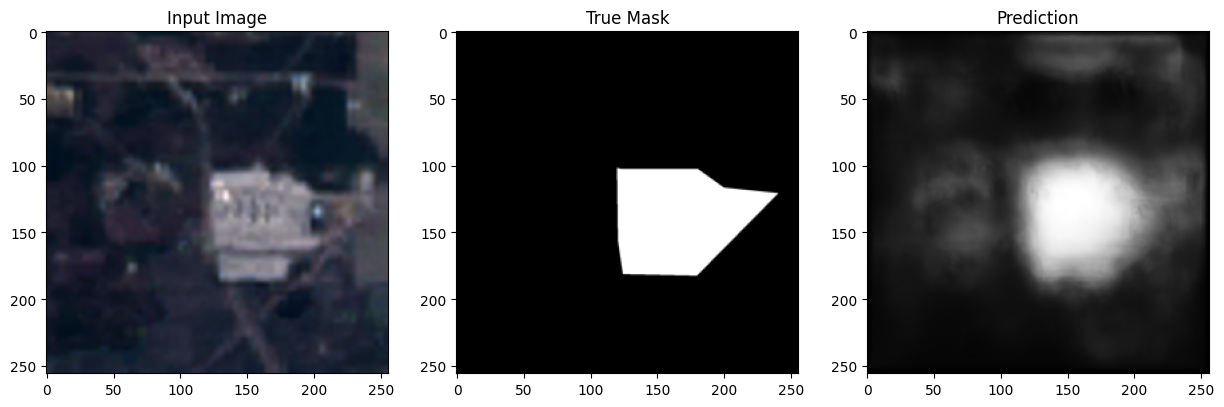

In [42]:
image_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat\ls8_156_AL_NG.tif"  # path to your specific image
mask_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary\bilabels_156.png"  # path to your specific mask

predict_specific_image_unet(model, image_path, mask_path, target_size=(256, 256))

### Pretrained U-Net with Augmentation

In [18]:
class AugmentedDataGenerator(Sequence):
    def __init__(self, image_data_generator, mask_data_generator, images, masks, batch_size):
        self.image_data_generator = image_data_generator
        self.mask_data_generator = mask_data_generator
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.image_gen = self.image_data_generator.flow(images, batch_size=batch_size, seed=1)
        self.mask_gen = self.mask_data_generator.flow(masks, batch_size=batch_size, seed=1)
        
    def __len__(self):
        return min(len(self.image_gen), len(self.mask_gen))
    
    def __getitem__(self, index):
        # Get the augmented image and mask
        image_batch = self.image_gen[index]
        mask_batch = self.mask_gen[index]
        
        return image_batch, mask_batch
    
    def on_epoch_end(self):
        # Reset the generators if needed
        self.image_gen.reset()
        self.mask_gen.reset()

image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of the custom data generator
train_generator = AugmentedDataGenerator(
    image_data_generator=image_datagen,
    mask_data_generator=mask_datagen,
    images=X_train_rgb,
    masks=y_train,
    batch_size=24
)

In [ ]:
aug_pretrained_unet_model = models.unet_2d(input_size=(256,256,3),
                                      filter_num=[64, 128, 256, 512, 1024], # same as in non-pretrained
                                      n_labels=1,
                                      stack_num_down=2,
                                      stack_num_up=2, 
                                      activation='ReLU',
                                      output_activation='Sigmoid',
                                      batch_norm=False,
                                      pool='max',
                                      unpool= True, 
                                      backbone='VGG16', # rec
                                      weights='imagenet',
                                      freeze_backbone=True,
                                      freeze_batch_norm=True)

aug_pretrained_unet_model.compile(loss='binary_crossentropy',
                              optimizer=Adam(learning_rate = 1e-4),
                              metrics=['accuracy'])

In [19]:
aug_pretrained_unet_history = aug_pretrained_unet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train_rgb) // 24,
    epochs=10,
    validation_data=(X_test_rgb, y_test),
    verbose=1,
    shuffle=False
)

# Save the trained model and training history
aug_pretrained_unet_model.save('aug_pretrained_unet_model.h5')
save_history(aug_pretrained_unet_history, r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\aug_pretrained_unet_history.pkl')


Epoch 1/10


C:\Users\Jasmin Steinbrecher\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 4840s 29s/step - accuracy: 0.8054 - loss: 0.4404 - val_accuracy: 0.8017 - val_loss: 0.4290
Epoch 2/10


C:\Program Files\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


167/167 ━━━━━━━━━━━━━━━━━━━━ 138s 826ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8017 - val_loss: 0.4290
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4837s 29s/step - accuracy: 0.8194 - loss: 0.3842 - val_accuracy: 0.8029 - val_loss: 0.4270
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 139s 830ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8029 - val_loss: 0.4270
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4826s 29s/step - accuracy: 0.8203 - loss: 0.3799 - val_accuracy: 0.8055 - val_loss: 0.4199
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 139s 831ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8055 - val_loss: 0.4199
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4837s 29s/step - accuracy: 0.8249 - loss: 0.3712 - val_accuracy: 0.8081 - val_loss: 0.4156
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 138s 827ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8081 - val_loss: 0.4156
Epoch 9/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4832s 29s/step - a

NameError: name 'save_history' is not defined

In [21]:
save_history(aug_pretrained_unet_history, r'C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\aug_pretrained_unet_history.pkl')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction shape: (256, 256, 1)


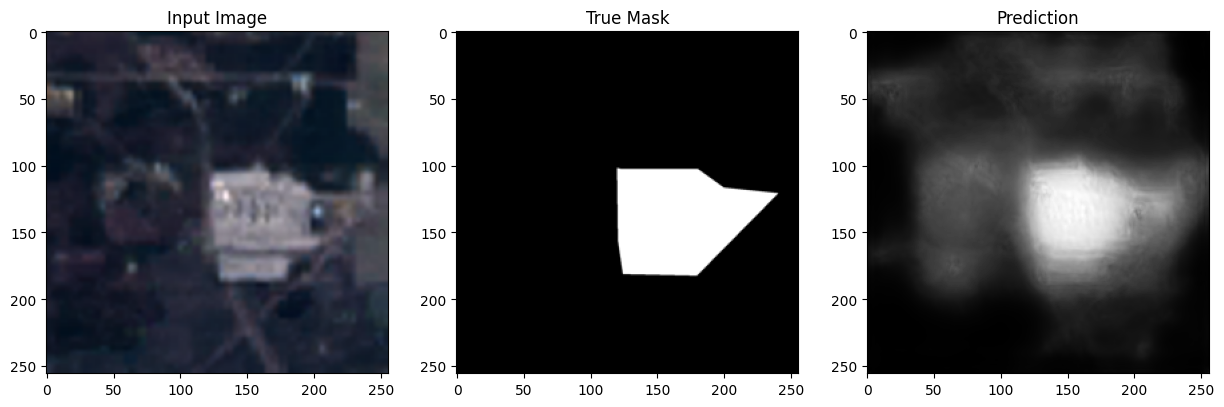

In [24]:
image_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\uspp_landsat\ls8_156_AL_NG.tif"  # path to your specific image
mask_path = r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\binary\bilabels_156.png"  # path to your specific mask

predict_specific_image_unet(aug_pretrained_unet_model, image_path, mask_path, target_size=(256, 256))

In [25]:
_, acc = aug_pretrained_unet_model.evaluate(X_test_rgb, y_test)
print("Accuracy = ", (acc * 100.0), "%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 126s 9s/step - accuracy: 0.8045 - loss: 0.4181
Accuracy =  80.92766404151917 %


In [37]:
def load_history(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

# print("Keys in the history dictionary:")
# for key in loaded_history.keys():
#     print(key)

In [39]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


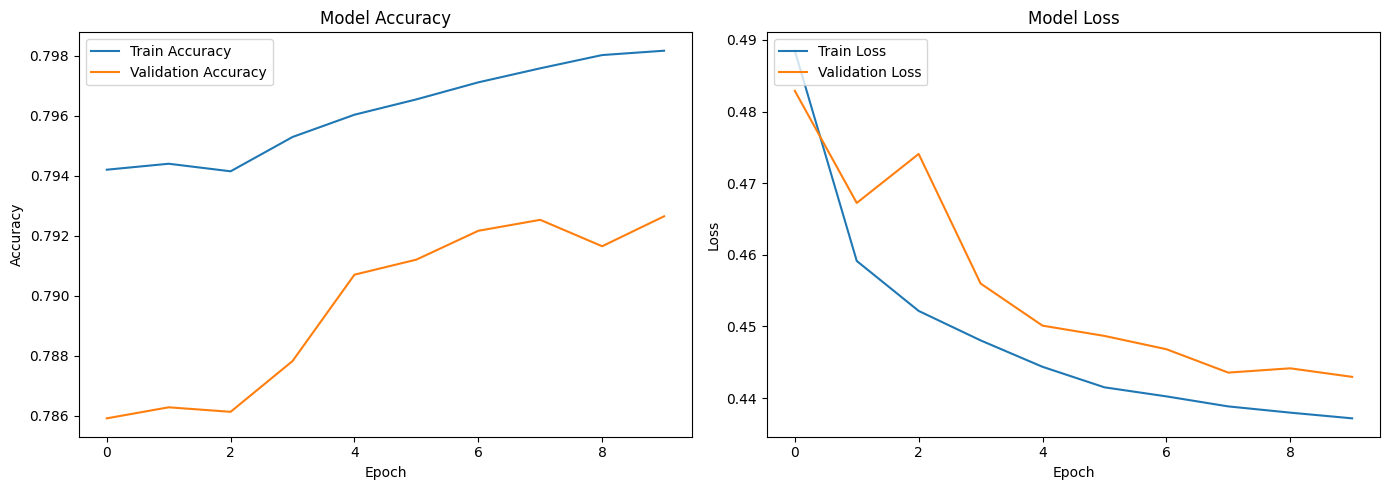

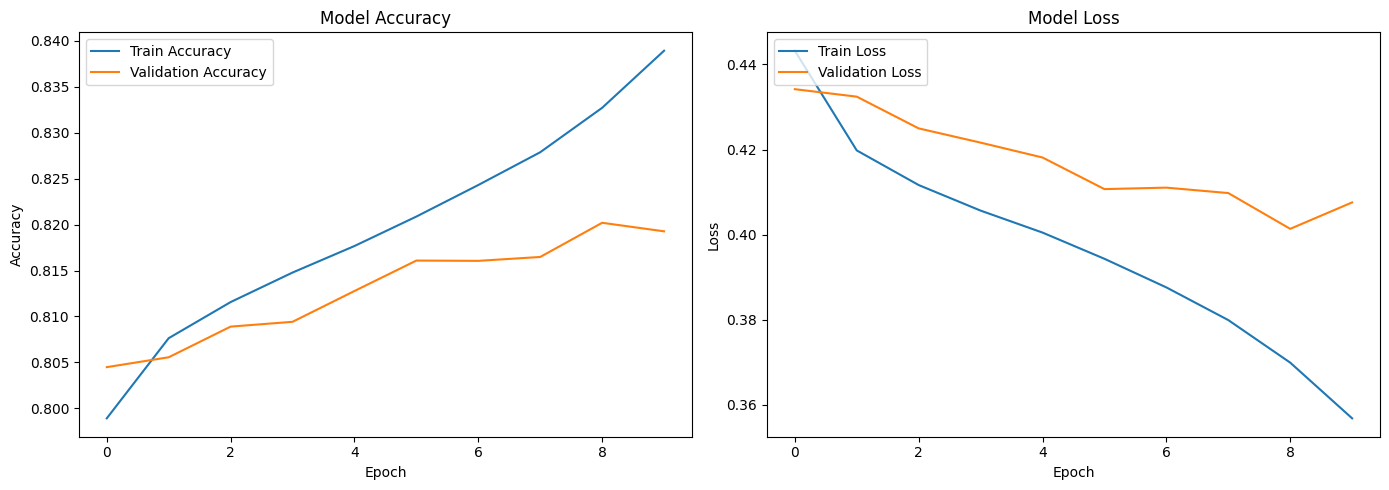

In [42]:
cnn_hist = load_history(r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\custom_CNN.pkl")
plot_history(cnn_hist)
pre_unet_hist = load_history(r"C:\Users\Jasmin Steinbrecher\OneDrive - TUM\semester 6\Al4EO\final project\new_pretrained_unet_history.pkl")
plot_history(pre_unet_hist)

In [ ]:
# Open the TIFF file
with rasterio.open(r"C:\Users\Jasmin Steinbrecher\Downloads\True_Color_Image_2017.tif") as src:
    # Read all bands
    bands = [src.read(i) for i in range(1, src.count + 1)]
    
    # Get metadata
    metadata = src.meta
    transform = src.transform

# Check pixel value ranges
for i, band in enumerate(bands):
    print(f"Band {i+1} - min: {band.min()}, max: {band.max()}")

# Display images based on the number of bands
if len(bands) == 1:
    # Single band image
    img = bands[0]
    
    # Normalize data for display
    img = np.clip(img, 0, 30000)  # Adjust if needed
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0-1

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')  # Use 'gray' for grayscale
    plt.colorbar()
    plt.title('TIFF Image Visualization (Single Band)')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()
elif len(bands) >= 3:
    # Multi-band image, assuming RGB
    img_rgb = np.stack(bands[:3], axis=-1)  # Combine first 3 bands into an RGB image

    # Normalize data for display
    img_rgb = np.clip(img_rgb, 0, 30000)  # Adjust if needed
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())  # Normalize to 0-1

    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title('TIFF Image RGB Visualization')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()
else:
    print("Insufficient bands to visualize image correctly.")
